In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as tud
import numpy as np
from typing import Callable, Any, List, Dict
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import time


class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(16)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(32)
        )
        self.full_connection = nn.Sequential(
            nn.Linear(in_features=32*26*26, out_features=512), 
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=512, out_features=num_classes)
        )
    def forward(self, x): 
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), 32 * 26 * 26)
        y = self.full_connection(x)
        return y
#     def __init__(self):
#         super(Net, self).__init__()
#         # 1 input image channel, 6 output channels, 3x3 square convolution
#         # kernel
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 3)
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120) 
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         # (N, 1, 28, 28) -> (N, 6, 24, 24)
#         x = torch.relu(self.conv1(x))
#         # (N, 6, 24, 24) -> (N, 6, 12, 12)
#         x = self.pool1(x)
#         # (N, 6, 12, 12) -> (N, 16, 10, 10)
#         x = torch.relu(self.conv2(x))
#         # (N, 16, 10, 10) -> (N, 16, 5, 5)
#         x = self.pool2(x)
#         # (N, 16, 5, 5) -> (N, 16 * 5 * 5)
#         x = x.view(-1, self.num_flat_features(x))
#         # (N, 16 * 5 * 5) -> (N, 120)
#         x = torch.relu(self.fc1(x))
#         # (N, 120) -> (N, 84)
#         x = torch.relu(self.fc2(x))
#         # (N, 84) -> (N, 10)
#         x = self.fc3(x)
#         return x

#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features



In [51]:
if __name__ == '__main__':
    # Load data set
    mnist = fetch_openml('mnist_784', data_home='./')
    X = mnist.data / 255
    Y = mnist.target
#     X = mnist.data[:7000] / 255
#     Y = mnist.target[:7000]
    Y = np.array([int(n) for n in Y])
    print(X.shape, Y.shape)


(70000, 784) (70000,)


Epoch: 1   Train Loss: 0.2858   Test Loss: 0.0725   Accuracy: 0.9776   Time[h]: 0.01
Epoch: 2   Train Loss: 0.0435   Test Loss: 0.0599   Accuracy: 0.9815   Time[h]: 0.03
Epoch: 3   Train Loss: 0.0292   Test Loss: 0.0507   Accuracy: 0.9847   Time[h]: 0.04


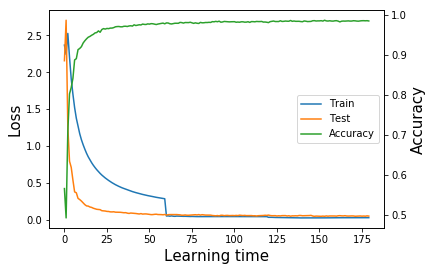

In [81]:
if __name__ == '__main__':
    num_classes = 10
    device = 'cuda:0'
    model = Net(num_classes)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(), lr = lr)
    optimizer = optim.Adam(model.parameters())

    # Create train and teach data
    N = X.shape[0]
    rate = 1 / 7
    N_test = int(N * rate)
    N_train = N - N_test
    batch_size = 1000
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=rate)
    X_train = torch.tensor(X_train, dtype=torch.float).reshape(N_train, 1, 28, 28)
    X_test = torch.tensor(X_test, dtype=torch.float).reshape(N_test, 1, 28, 28)
    Y_train = torch.LongTensor(Y_train)
    Y_test = torch.LongTensor(Y_test)
    train_data = tud.TensorDataset(X_train, Y_train)
    train_iter = tud.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data = tud.TensorDataset(X_test, Y_test)
    test_iter = tud.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    data_num = len(test_iter.dataset)
    
    # Learning data
    epochs = 3
    Loss_train = []
    Loss_test = []
    Accuracy = []
    t0 = time.time()
    for epoch in range(1, epochs + 1):
        loss_train = []
        for x_train, y_train in train_iter:
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            optimizer.zero_grad()
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            loss_train.append(loss.item())
            correct = 0
            loss_test = []
            accuracy = []
            for x_test, y_test in test_iter:
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                y_pred = model(x_test)
                loss = criterion(y_pred, y_test)
                _, predicted = torch.max(y_pred.data, 1)
                correct += predicted.eq(y_test.data.view_as(predicted)).sum()
                loss_test.append(loss.item())
            Loss_train.append(np.mean(loss_train))
            Loss_test.append(np.mean(loss_test))
            Accuracy.append((correct.item() / data_num))
            
        if epoch % 1 == 0 or epoch == 1:
            print('Epoch:', epoch,
                  '  Train Loss:', '{:.4f}'.format(Loss_train[-1]),
                  '  Test Loss:', '{:.4f}'.format(Loss_test[-1]),
                  '  Accuracy:', '{:.4f}'.format(Accuracy[-1]),
                  '  Time[h]:', '{:.2f}'.format((time.time() - t0)/3600),
                 )
    
    # Plot Learning Curve
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(np.arange(len(Loss_train)), Loss_train, label='Train', color='tab:blue')
    ax1.plot(np.arange(len(Loss_test)), Loss_test, label='Test', color='tab:orange')
    ax1.set_xlabel('Learning time', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)
    ax2 = ax1.twinx()
    ax2.plot(np.arange(len(Accuracy)), Accuracy, label='Accuracy', color='tab:green')
    ax2.set_ylabel('Accuracy', fontsize=15)
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='center right')
